# Population Trends Exploration

**Objectives**
- Build a clean, reproducible dataset from raw API exports.
- Compare population growth since 2000.
- Provide a simple ranking view for dashboard use.

In [4]:
import pandas as pd
from pathlib import Path
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


PROJECT_ROOT = Path("..").resolve()

processed_pop = PROJECT_ROOT / "data/processed/processed_population_data.csv"
fetch_script = PROJECT_ROOT / "scripts/data-fetch/fetch_population.sh"
process_script = PROJECT_ROOT / "src/data-process/process_population_data.py"

if not processed_pop.is_file():
    print("Processed data not found. Running pipeline...")

    subprocess.run(["bash", str(fetch_script)], check=True)
    subprocess.run(["python3", str(process_script)], check=True)

df = pd.read_csv(processed_pop)
df.head()


,Country,Year,Population
0,Australia,2024,27196812
1,Australia,2023,26659922
2,Australia,2022,26018721
3,Australia,2021,25685412
4,Australia,2020,25649248


## Data Load and Preparation

This section pulls processed population data. If the CSV is missing, it triggers the fetch and processing scripts to rebuild it from the raw JSON exports.

**Why this matters:** it makes the notebook reproducible for reviewers and easy to re-run.

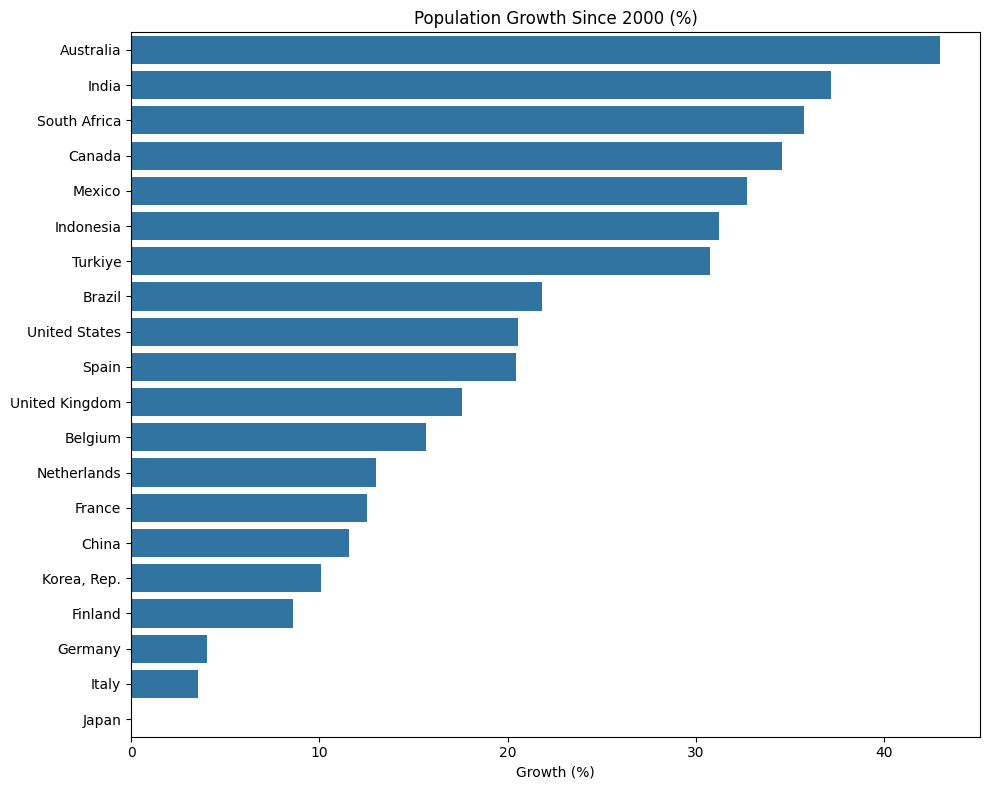

In [7]:
subset = df[df["Year"] >= 2000].copy()

subset["GrowthPercent"] = (
    subset["Population"]
    / subset.groupby("Country")["Population"].transform("min")
    - 1
) * 100

latest_growth = subset[subset["Year"] == subset["Year"].max()]
latest_growth = latest_growth.sort_values("GrowthPercent", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=latest_growth,
    y="Country",
    x="GrowthPercent"
)

plt.title("Population Growth Since 2000 (%)")
plt.xlabel("Growth (%)")
plt.ylabel("")
plt.tight_layout()
plt.show()


## Growth Since 2000

We compute percentage growth relative to each country's minimum population since 2000 and plot the latest year for a quick cross-country comparison.

This view is intentionally simple and dashboard-friendly, highlighting relative change rather than absolute size.

## Population Ranking by Country (Latest Year)

This section extracts the most recent population data available and ranks countries by total population. It creates a compact comparison table suitable for reporting or dashboard use.

**Steps performed:**
1. Identify the latest year in the dataset.
2. Pivot populations for baseline years and the latest year.
3. Compute growth for 1980→2000 and 2000→latest.
4. Format values for readability.

In [ ]:
latest_year = df["Year"].max()

comparison = (
    df[df["Year"].isin([1980, 2000, latest_year])]
        .pivot(index="Country", columns="Year", values="Population")
        .reset_index()
)

growth_1 = (
    (comparison[2000] - comparison[1980]) / comparison[1980] * 100
)

growth_2 = (
    (comparison[latest_year] - comparison[2000]) / comparison[2000] * 100
)

comparison = comparison.sort_values(
    by=latest_year, ascending=False
)

for col in [1980, 2000, latest_year]:
    comparison[col] = comparison[col].map("{:,}".format)

comparison.insert(2, "Growth %", growth_1.map("{:.1f}%".format))
comparison.insert(4, "Growth % ", growth_2.map("{:.1f}%".format))

comparison.columns = [
    "Country",
    "1980",
    "Growth %",
    "2000",
    "Growth %",
    str(latest_year),
]

comparison


,Country,1980,Growth %,2000,Growth %,2024
8,India,"687,354,025",53.9%,"1,057,922,733",37.1%,"1,450,935,791"
4,China,"981,235,000",28.7%,"1,262,645,000",11.6%,"1,408,975,000"
19,United States,"227,225,000",24.2%,"282,162,411",20.5%,"340,110,988"
9,Indonesia,"148,950,540",45.1%,"216,077,790",31.2%,"283,487,931"
2,Brazil,"121,207,461",43.6%,"174,018,282",21.8%,"211,998,573"
13,Mexico,"67,300,334",46.5%,"98,625,552",32.7%,"130,861,007"
11,Japan,"116,807,000",8.6%,"126,843,000",-2.3%,"123,975,371"
17,Turkiye,"45,408,815",44.1%,"65,425,961",30.7%,"85,518,661"
7,Germany,"78,288,576",5.0%,"82,211,508",1.6%,"83,516,593"
18,United Kingdom,"56,314,216",4.6%,"58,892,514",17.5%,"69,226,000"


## Notes for Reviewers

- The source data comes from World Bank population indicators, cached as JSON in `data/raw/population`.
- Values are used as reported; missing values are filtered out during processing.
- The analysis emphasizes interpretability over complex modeling, which is appropriate for a dashboard baseline.